# DCGAN MNIST 데이터셋 실습

참고: https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko

In [1]:
!pip install tensorflow-gpu==2.0.0-rc1
!pip install imageio

     |████████████████████████████████| 380.5 MB 5.4 kB/s 
     |████████████████████████████████| 501 kB 54.0 MB/s 
     |████████████████████████████████| 4.3 MB 57.5 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 


In [67]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import tensorflow as tf
import time

from IPython import display

## 데이터셋 로딩

In [68]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [69]:
train_images.shape

(60000, 28, 28)

In [70]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화

`from_tensor_slices` 함수로 반환되는 `BatchDataset` 타입의 데이터는 `shuffle` 메소드로 매 Epochs에서 데이터를 섞어줄 수 있고, 지정된 batch size 만큼 자동으로 분할하여 반복 가능한 객체를 만들어 줌

In [71]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# 데이터 배치를 만들고 섞음
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 모델 생성

### Generator

In [72]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

아직 훈련되지 않은 생성자를 이용해서 이미지 생성

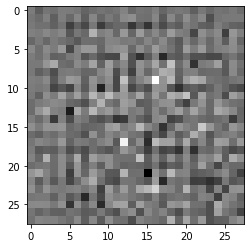

In [73]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator

In [74]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [75]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00198203]], shape=(1, 1), dtype=float32)


### loss 함수 및 optimizer 정의

In [76]:
# 이 메서드는 cross entropy loss를 계산하기 위해 헬퍼 (helper) 함수를 반환함
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [77]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [87]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [79]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

**체크포인트 저장**

In [80]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 훈련 과정 정의

In [82]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [92]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_image, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
      
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [93]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # GIF를 위한 이미지를 바로 생성
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)
        
        # 15 에포크가 지날 때마다 모델을 저장
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # 마지막 에포크가 끝난 후 생성
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)

**이미지 생성 및 저장**

In [94]:
def generate_and_save_images(model, epoch, test_input):
    # `training`이 False로 맞춰짐
    # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됨
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### Training

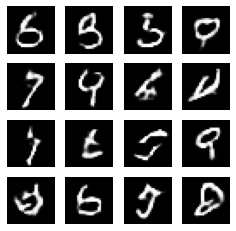

CPU times: user 2min 10s, sys: 10.1 s, total: 2min 20s
Wall time: 9min 11s


In [95]:
%%time
train(train_dataset, EPOCHS)

In [96]:
# 마지막 체크포인트 복구
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### GIF 생성

In [97]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줌
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

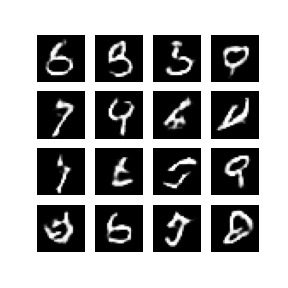

In [98]:
display_image(EPOCHS)

In [99]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

In [100]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>